# HQNN-Quanv

Running on local machine, preferably using Pennylane's `lightning.qubit`.


## Key notes on this model

- The ultimate goal of the model training is to find a **measurement basis** (by tweaking variational gate parameters) that tells us the most information about a fragment of a picture confined by the quantum kernel.
- Finally, for each wire, the expectation value of an **arbitrary operator** is calculated to obtain the classical output. As it is a real number, **it represents the kernel’s output pixel**, while each wire yields a **different image channel**. For instance, a quanvolutional kernel of size 2 × 2 has a 4-qubit circuit, which transforms one input image into _four images of reduced size_.


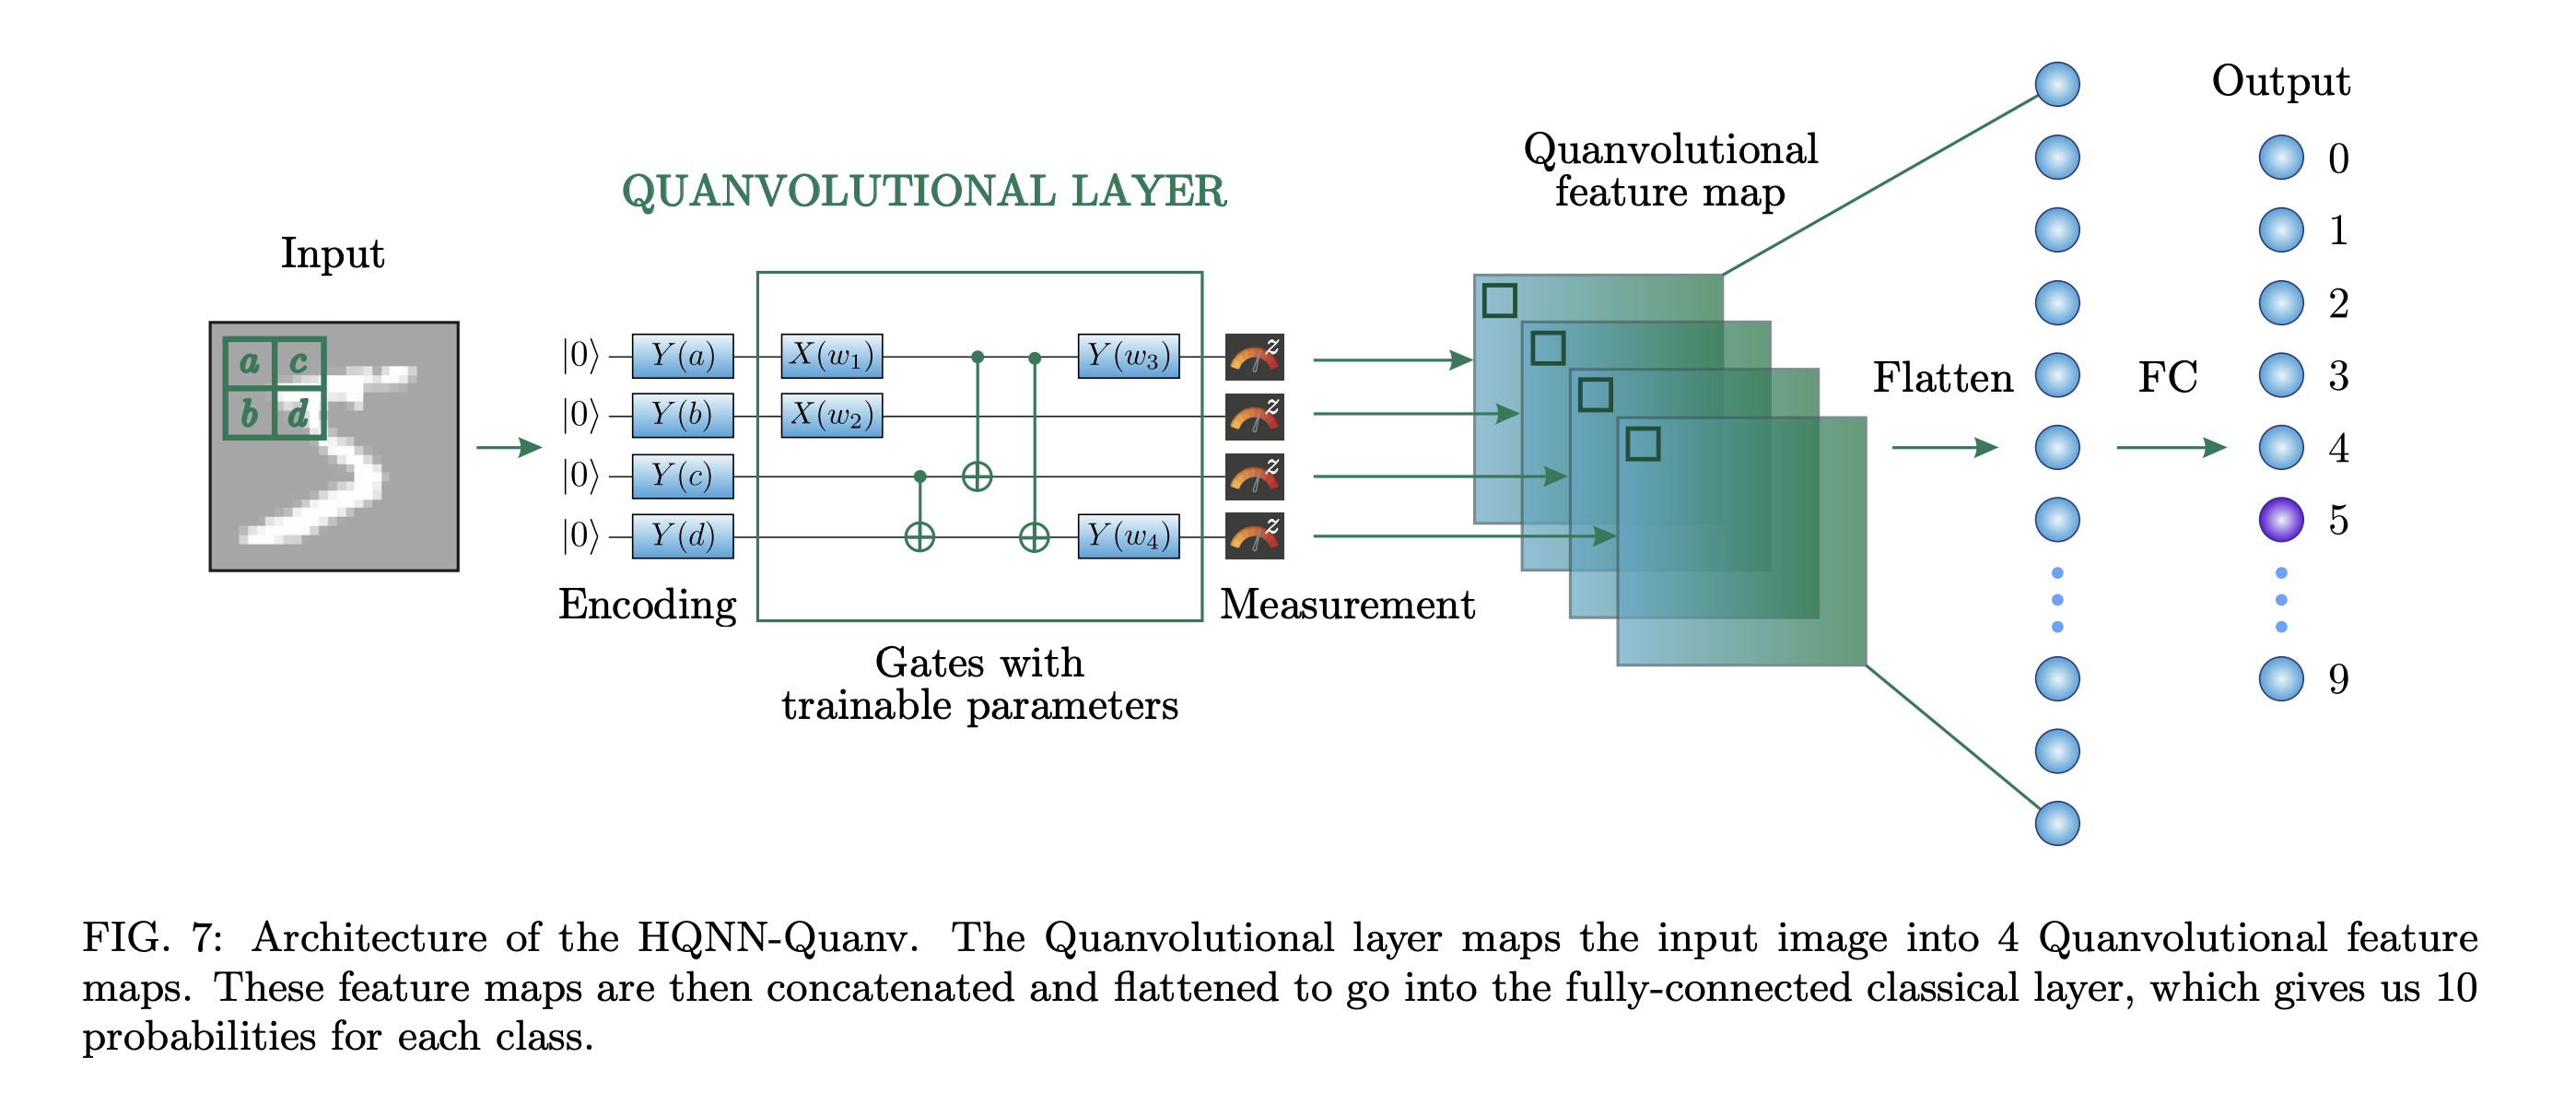


## Structure of the quantum kernel

First embed the pixels in the kernel to qubits, one qubit per pixel (2x2 kernel -> 4 qubits).

- This embedding will be done by first scaling the (0, 1) pixel value to (0, π) and then doing a Ry rotation by the scaled angle.

Then the variational circuit has 4 **parametrized** single-qubit rotations, and three CNOT gates (for the example of a 2x2 matrix)

Finally we measure the **expectation value** of the **Pauli-Z** operator for each qubit.

- This creates 4 output channels, each with one expectation value. "Each channel is a picture with 4 × 4 pixels." **what does this mean?**

The four output channels are then **flattened** and passed to a dense layer to generate probabilities for different classes.


In [43]:
# Imports
import torch.nn as nn
import pennylane as qml
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import random

In [19]:
class QuanvolutionalLayer(nn.Module):
    '''
    A PyTorch module for the quanvolutional layer.
    '''

    def __init__(self, kernel_size=4, depth=1):
        '''
        Args:
            kernel_size (int): The size of the kernel. e.g. passing 2 would result in a 2x2 kernel.
            depth (int): The number of repetitions of variational sections to use. 
                - This linearly affects the number of trainable parameters in the quanvolutional layer.
            device (str): The PennyLane device to use.
        '''
        super().__init__()

        self.kernel_size = kernel_size
        self.n_qubits = kernel_size**2
        self.depth = depth

        # Learnable weights for the variational circuit
        self.weights = nn.Parameter(torch.randn(self.depth, self.n_qubits))

        
        # --- Creating the PennyLane device to run circuits on ---
        dev = qml.device('lightning.qubit', wires=self.n_qubits)

        @qml.qnode(dev, interface='torch', diff_method='adjoint')
        def quantum_circuit(inputs, weights):
            # --- Encoding the inputs into Y-rotation angles ---
            # Scale inputs to [0, pi] range
            scaled_inputs = inputs * torch.pi
            qml.AngleEmbedding(scaled_inputs, wires=range(self.n_qubits), rotation='Y')

            # --- Define the Variational layers (trainable params) ---
            # Reshape the weights for easier indexing
            weights = weights.reshape(self.depth, self.n_qubits)
            for layer_id in range(self.depth):
                # --- TODO: Support other kernel sizes ---
                # X gates with trainable parameters on qubits 0 and 1
                qml.RX(weights[layer_id, 0], wires=0)
                qml.RX(weights[layer_id, 1], wires=1)
                # CNOT gates
                qml.CNOT(wires=[2, 3])
                qml.CNOT(wires=[0, 2])
                qml.CNOT(wires=[0, 3])
                # Y gates with trainable parameters on qubits 0 and 3
                qml.RY(weights[layer_id, 2], wires=0)
                qml.RY(weights[layer_id, 3], wires=3)

                # separate the layers with a barrier
                qml.Barrier(wires=range(self.n_qubits))

            # --- Measurement of the qubits ---
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

        self.quantum_kernel = quantum_circuit

        # --- Display the circuit for visualization ---
        print("--- Quantum Circuit Structure ---")
        # Create dummy inputs and weights for drawing
        dummy_inputs = torch.zeros(self.n_qubits)
        dummy_weights = torch.zeros(self.depth * self.n_qubits)

        # Draw the circuit
        fig, ax = qml.draw_mpl(quantum_circuit)(dummy_inputs, dummy_weights)
        plt.show()
        print("---------------------------------")

    def forward(self, x):
        '''
        Forward pass for the quanvolutional layer.
        '''

        # assume x is a batch of patches of shape (batch, n_qubits)
        batch_size = x.shape[0]
        weights = torch.zeros(self.depth * self.n_qubits, device=x.device, dtype=x.dtype)

        outputs = []
        for i in range(batch_size):
            out = torch.tensor(self.quantum_kernel(x[i], weights), device=x.device, dtype=x.dtype)
            outputs.append(out)

        return torch.stack(outputs)

--- Quantum Circuit Structure ---


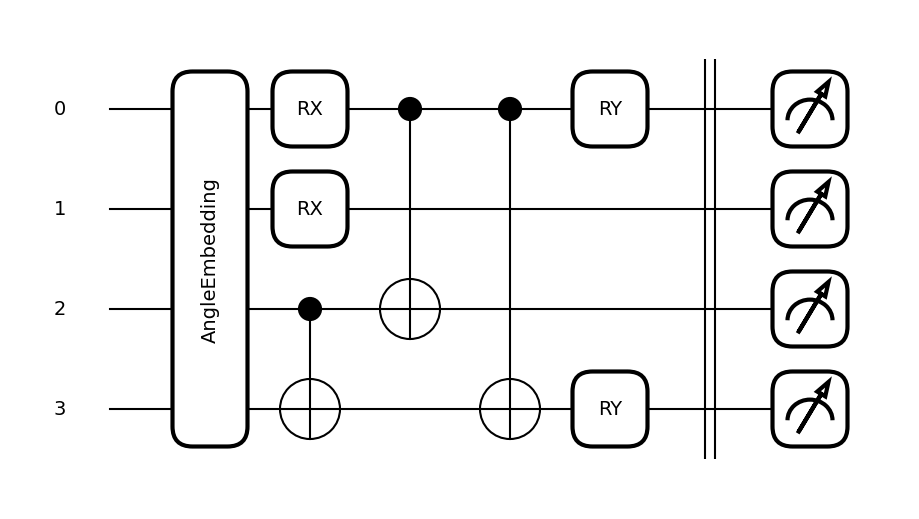

---------------------------------
Input shape: torch.Size([3, 4])
Output shape: torch.Size([3, 4])
Output: tensor([[ 0.7344,  0.9068,  0.2850,  0.2804],
        [-0.7491,  0.6242, -0.7145,  0.0685],
        [-0.9945, -0.0461, -0.0630,  0.0518]])


In [20]:
# --- Testing the Quanvolutional Layer ---
kernel_size = 2
depth = 1
batch_size = 3

layer = QuanvolutionalLayer(kernel_size=kernel_size, depth=depth)
dummy_input = torch.rand(batch_size, kernel_size**2)

output = layer(dummy_input)


print("Input shape:", dummy_input.shape)
print("Output shape:", output.shape)
print("Output:", output)

## Constructing the full model


In [21]:
class HQNNQuanv(nn.Module):
    def __init__(self, image_size=8, kernel_size=2, depth=1, n_classes=10):
        super().__init__()

        self.kernel_size = kernel_size
        self.n_qubits = kernel_size ** 2
        self.depth = depth

        # Quanvolutional layer
        self.quanv = QuanvolutionalLayer(kernel_size=kernel_size, depth=depth)

        # Calculate output size after sliding the kernel
        # For stride=1, padding=0:
        self.feature_map_size = image_size - kernel_size + 1
        self.n_channels = self.n_qubits # 4 for 2x2 kernel

        # Fully connected layer
        self.Dense = nn.Linear(self.n_channels * self.feature_map_size**2, n_classes)

    def forward(self, x):
        # x: (batch, 1, H, W)
        batch_size = x.shape[0]
        patches = []
        # Extract patches and apply quanvolution
        for img in x:
            # img: (1, H, W)
            img_patches = []
            for i in range(self.feature_map_size):
                for j in range(self.feature_map_size):
                    patch = img[0, i:i+self.kernel_size, j:j+self.kernel_size].reshape(-1)
                    img_patches.append(patch)
            
            img_patches = torch.stack(img_patches)      # (n_patches, n_qubits)
            quanv_out = self.quanv(img_patches)         # (n_patches, n_qubits)
            quanv_out = quanv_out.transpose(0, 1)       # (n_qubits, n_patches)
            quanv_out = quanv_out.reshape(self.n_channels, self.feature_map_size, self.feature_map_size)
            patches.append(quanv_out)

        x = torch.stack(patches)    # (batch_size, n_channels, feature_map_size, feature_map_size)

        x = x.view(batch_size, -1)  # Flatten

        x = self.Dense(x) # Fully connected layer

        return x

--- Quantum Circuit Structure ---


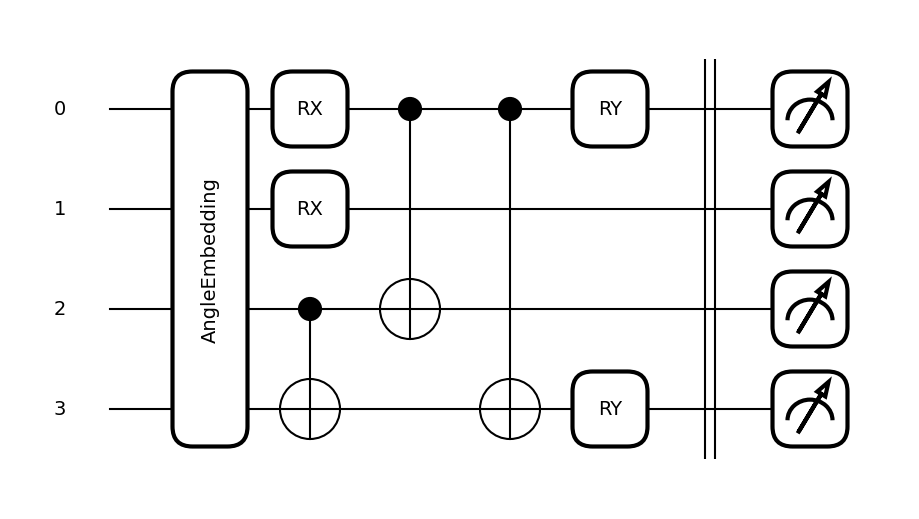

---------------------------------
Input shape: torch.Size([2, 1, 28, 28])
Output shape: torch.Size([2, 10])
Output: tensor([[-0.2851, -0.0359, -0.4715,  0.6302,  0.9201, -0.0961, -0.2033,  0.0119,
         -0.2126, -0.0186],
        [ 0.1654, -0.2916, -0.0836,  0.0307,  0.5674,  0.2449,  0.3408, -0.3245,
          0.0400,  0.5196]], grad_fn=<AddmmBackward0>)


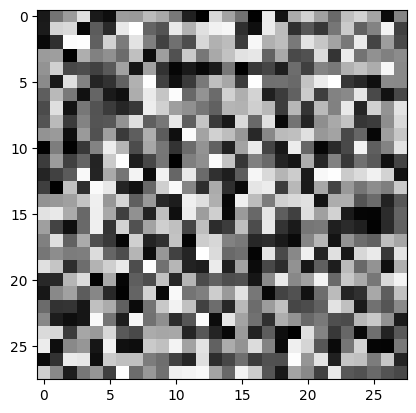

In [22]:
# --- Testing the full HQNNQuanv model ---
batch_size = 2
image_size = 28
kernel_size = 2
depth = 1
n_classes = 10

model = HQNNQuanv(image_size=image_size, kernel_size=kernel_size, depth=depth, n_classes=n_classes)

# Create a dummy batch of grayscale images (values ranging [0,1])
dummy_images = torch.rand(batch_size, 1, image_size, image_size)
# Visualize one of the dummy images
plt.imshow(dummy_images[0, 0].detach().numpy(), cmap='gray')

# Run the test forward passs
output = model(dummy_images)

print("Input shape:", dummy_images.shape)
print("Output shape:", output.shape)
print("Output:", output)


## Training


In [32]:
def train_hqnn_quanv(model, train_loader, test_loader, device, epochs=20, learning_rate=0.01):
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train() # put the model in training mode

        train_correct = 0
        train_total = 0
        running_loss = 0.0
        for step, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Reset gradients to zero
            optimizer.zero_grad()
            
            # Perform forward pass
            outputs = model(images)

            # Evaluate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Perform backward pass and parameter update
            loss.backward()
            optimizer.step()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Print metrics every 10 steps
            if (step + 1) % 10 == 0 or (step + 1) == len(train_loader):
                avg_loss = running_loss / (step + 1)
                acc = train_correct / train_total
                print(f"Epoch [{epoch+1}/{epochs}] Step [{step+1}/{len(train_loader)}] "
                      f"Loss: {avg_loss:.4f} | Acc: {acc:.3f}")

        train_acc = train_correct / train_total

        # --- Evaluation ---
        model.eval() # set model to evaluation mode
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
            
        test_acc = test_correct / test_total
        avg_epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_epoch_loss:.4f} | "
              f"Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}")

In [25]:
# --- Data Preparation ---
transform = transforms.Compose([
    transforms.Resize((14, 14), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor()
])

# Download MNIST and use only 600 images
mnist_full = datasets.MNIST(root='./data/mnist-quanv', train=True, download=True, transform=transform)
mnist_subset, _ = torch.utils.data.random_split(mnist_full, [600, len(mnist_full)-600])
train_set, test_set = random_split(mnist_subset, [500, 100])

# Initialize DataLoaders
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

  0%|          | 0.00/9.91M [00:00<?, ?B/s]

100%|██████████| 9.91M/9.91M [00:01<00:00, 8.50MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.31MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.83MB/s]


In [34]:
# --- Hyperparameters ---
image_size = 14  # Reduced size after resizing
kernel_size = 2
depth = 1
n_classes = 10

epochs = 10
learning_rate = 0.01

--- Quantum Circuit Structure ---


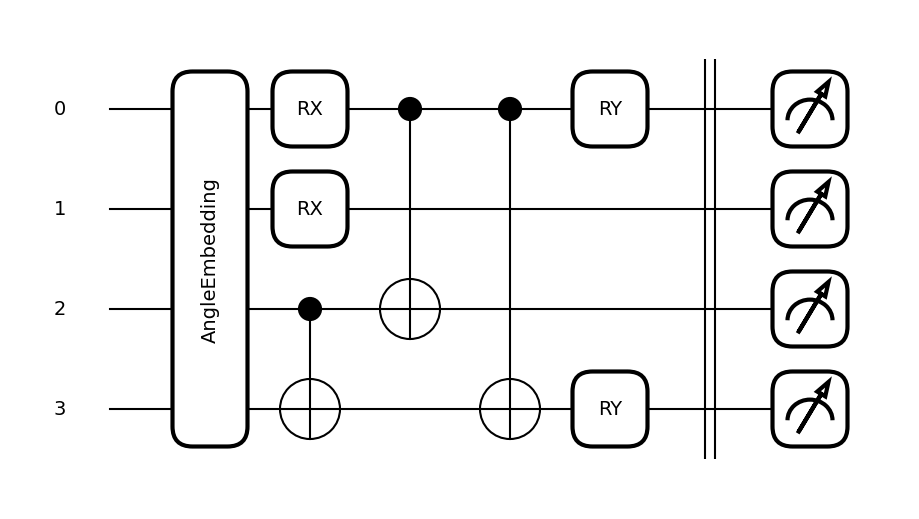

---------------------------------
Epoch [1/10] Step [10/32] Loss: 3.0377 | Acc: 0.294
Epoch [1/10] Step [20/32] Loss: 2.2689 | Acc: 0.409
Epoch [1/10] Step [30/32] Loss: 1.7268 | Acc: 0.531
Epoch [1/10] Step [32/32] Loss: 1.6340 | Acc: 0.544
Epoch 1/10 | Train Loss: 1.6340 | Train Acc: 0.544 | Test Acc: 0.800
Epoch [2/10] Step [10/32] Loss: 0.4289 | Acc: 0.844
Epoch [2/10] Step [20/32] Loss: 0.3690 | Acc: 0.872
Epoch [2/10] Step [30/32] Loss: 0.4163 | Acc: 0.856
Epoch [2/10] Step [32/32] Loss: 0.3997 | Acc: 0.858
Epoch 2/10 | Train Loss: 0.3997 | Train Acc: 0.858 | Test Acc: 0.830
Epoch [3/10] Step [10/32] Loss: 0.2668 | Acc: 0.919
Epoch [3/10] Step [20/32] Loss: 0.2596 | Acc: 0.906
Epoch [3/10] Step [30/32] Loss: 0.2504 | Acc: 0.915
Epoch [3/10] Step [32/32] Loss: 0.2499 | Acc: 0.914
Epoch 3/10 | Train Loss: 0.2499 | Train Acc: 0.914 | Test Acc: 0.770
Epoch [4/10] Step [10/32] Loss: 0.4109 | Acc: 0.869
Epoch [4/10] Step [20/32] Loss: 0.3484 | Acc: 0.881
Epoch [4/10] Step [30/32] Loss:

In [35]:

# --- Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HQNNQuanv(image_size=image_size, kernel_size=kernel_size, depth=depth, n_classes=n_classes).to(device)

# --- Run the Training ---
train_hqnn_quanv(model, train_loader, test_loader, device, epochs=epochs, learning_rate=learning_rate)

In [ ]:
import os

# Find a unique filename to avoid overwriting existing models
base = 'hqnn_quanv_mnist_lightning'
ext = '.pth'
filename = base + ext
counter = 1
while os.path.exists(filename):
    filename = f"{base}_{counter}{ext}"
    counter += 1

# Save the model to a unique file
# torch.save(model.state_dict(), filename)
print(f"Model saved to {filename}")

## Using the model to make predictions


In [41]:
def load_model(filepath):
    state_dict = torch.load(filepath)

    # Create a new model instance with the same architecture
    loaded_model = HQNNQuanv(
        image_size=image_size,
        kernel_size=kernel_size,
        depth=depth,
        n_classes=n_classes
    )
    # Load the state dictionary
    loaded_model.load_state_dict(state_dict)
    return loaded_model

In [47]:
# --- Prediction on New Images ---
def predict_image(model, image_tensor):
    # Now we have a proper model instance
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)  # Get probabilities
        
        # Print probabilities for each class
        for i, prob in enumerate(probabilities[0]):
            print(f"Class {i}: {prob:.4f}")
            
        confidence, predicted_class = torch.max(probabilities, 1)

    if image_tensor.shape[0] == 1:
        return predicted_class.item(), confidence.item()
    else:
        return predicted_class.tolist(), confidence.tolist()

--- Quantum Circuit Structure ---


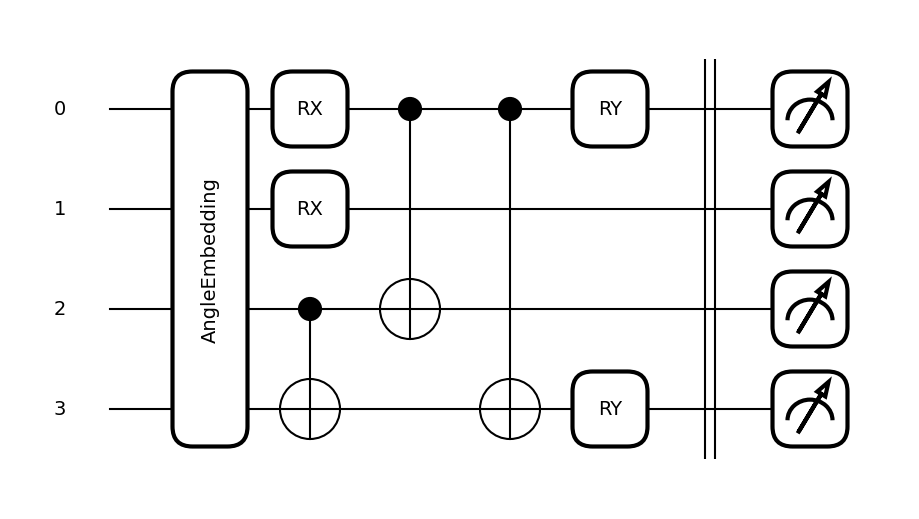

---------------------------------
Class 0: 0.0000
Class 1: 0.0000
Class 2: 1.0000
Class 3: 0.0000
Class 4: 0.0000
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.0000
Class 8: 0.0000
Class 9: 0.0000

--- Prediction ---
True Label: 2
Predicted Label: 2 with confidence 1.0000


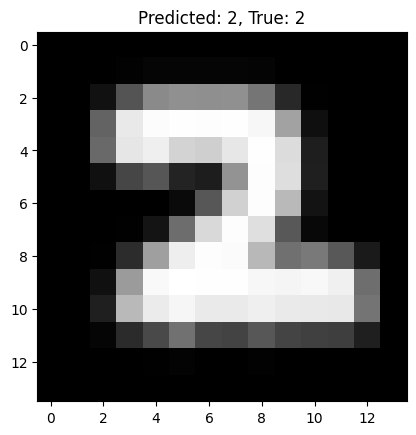

In [50]:
# 4. Test prediction on a single image
# Load the model from file
model_from_path = load_model('hqnn_quanv_mnist_lightning.pth')

# Select a random image from the test dataset
random_idx = random.randint(0, len(mnist_full) - 1)
img, label = mnist_full[random_idx]
img_batch = img.unsqueeze(0)  # Add batch dimension

predicted, confidence = predict_image(model_from_path, img_batch)
print(f"\n--- Prediction ---")
print(f"True Label: {label}")
print(f"Predicted Label: {predicted} with confidence {confidence:.4f}")

plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Predicted: {predicted}, True: {label}")
plt.show()